## Shioaji_CNN - 1 (Create CNN Model) 

### 本範例程式利用永豐python api的分K資料進行CNN模型訓練

Shioaji是永豐金證券提供的API介面，提供報價、下單、回報、帳務等功能<br>
官方連結:https://sinotrade.github.io/<br>
本範例程式碼著重於如何取得歷史股價並訓練CNN模型，並未對CNN模型的參數與架構特別調整。同理，也可將模型替換成LSTM或其他模型。

### 登入永豐帳號

In [1]:
import pandas as pd
key = pd.read_csv('key.csv')
account = key.iloc[0,0]
password = key.iloc[0,1]

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', hostname '203.66.91.161:80' IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up


### 取得歷史分K資料

In [2]:
import pandas as pd
ID = 2303
stock_ID = str(ID)

kbars = api.kbars(api.Contracts.Stocks[stock_ID], start="2020-01-01", end="2020-12-12")
df = pd.DataFrame({**kbars})
df.ts = pd.to_datetime(df.ts)
df

,Volume,Open,High,Close,ts,Low
0,439,16.45,16.45,16.45,2020-01-02 09:01:00,16.45
1,63,16.45,16.50,16.50,2020-01-02 09:02:00,16.45
2,17,16.50,16.50,16.50,2020-01-02 09:03:00,16.45
3,72,16.50,16.50,16.45,2020-01-02 09:04:00,16.45
4,16,16.45,16.50,16.50,2020-01-02 09:05:00,16.45
...,...,...,...,...,...,...
54461,0,46.15,46.15,46.15,2020-12-11 13:26:00,46.15
54462,0,46.15,46.15,46.15,2020-12-11 13:27:00,46.15
54463,0,46.15,46.15,46.15,2020-12-11 13:28:00,46.15
54464,0,46.15,46.15,46.15,2020-12-11 13:29:00,46.15


### 將分K收盤價轉成series

In [3]:
stock_price = pd.Series(df['Close'].values, index=df['ts'])
stock_price

ts
2020-01-02 09:01:00    16.45
2020-01-02 09:02:00    16.50
2020-01-02 09:03:00    16.50
2020-01-02 09:04:00    16.45
2020-01-02 09:05:00    16.50
                       ...  
2020-12-11 13:26:00    46.15
2020-12-11 13:27:00    46.15
2020-12-11 13:28:00    46.15
2020-12-11 13:29:00    46.15
2020-12-11 13:30:00    46.10
Length: 54466, dtype: float64

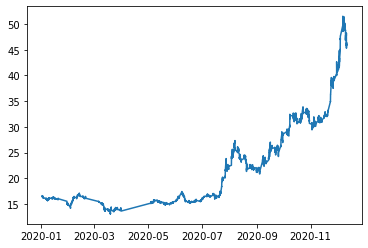

In [4]:
import matplotlib.pyplot as plt
plt.plot(stock_price)

### features & labels

#### CNN的input為過去200根分K的正規化收盤價，labels為10根分K後的報酬率

In [5]:
time_period = 200
cnn_X = []  
cnn_Y = []
indexs = []

In [6]:
import numpy as np
for i in range(0, len(stock_price) - time_period - 10, 20):  
    
    return_10days = stock_price.iloc[i+time_period+10] / stock_price.iloc[i+time_period]  
    cnn_Y.append(return_10days)
    indexs.append(stock_price.index[i+time_period]) 
    
    P = stock_price.iloc[i:i+time_period].values  
    if P.max() == P.min():   # 漲停或跌停
        yesterday = stock_price.iloc[i-270:i-269].index.date
        yesterday_close = stock_price[str(pd.Series(yesterday).iloc[0])][-1]
        if P.max() >= yesterday_close:   # 漲停
            One = np.array([1]*200)
            cnn_X.append(One)       # 漲停設為1
        if P.max() < yesterday_close:    # 跌停
            Zero = np.array([0]*200)
            cnn_X.append(Zero)    # # 跌停設為0
    else:
        cnn_X.append((P - P.min())/(P.max() - P.min()))   # 使股價正規化，介於0與1之間

#### cnn_X為200根分K正規化的收盤價

In [7]:
cnn_X[0]

array([0.  , 0.25, 0.25, 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.25, 0.  ,
       0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25, 0.25,
       0.25, 0.  , 0.  , 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.25, 0.  ,
       0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.  , 0.25, 0.25, 0.25, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 ,
       0.5 , 0.5 , 0.25, 0.25, 0.25, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.75,
       1.  , 0.75, 0.5 , 0.75, 0.75, 0.75, 0.5 , 0.5 , 0.75, 0.75, 0.5 ,
       0.75, 0.5 , 0.5 , 0.75, 0.5 , 0.75, 0.75, 0.75, 0.75, 0.5 , 0.5 ,
       0.75, 0.25, 0.75, 0.75, 0.75, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.25,
       0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.75, 0.5 , 0.5 , 0.5 , 0.75, 0.75,
       0.75, 0.5 , 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5 ,
       0.75, 0.75, 0.75, 0.5 , 0.5 , 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.5 , 0.75, 0.75, 0.75, 0.5 , 0.75, 0.

#### cnn_Y為10根分K後的報酬率

In [8]:
cnn_Y[0]

0.9969788519637461

In [9]:
import datetime

cnn_X = np.array(cnn_X)
cnn_Y = np.array(cnn_Y)
indexs_array = np.array(indexs)

# Reshape features and labels
cnn_X = cnn_X.reshape(len(cnn_X), time_period, 1)
cnn_Y = cnn_Y.reshape(len(cnn_Y), 1)

# Split traning and testing data
cnn_X_train = cnn_X[indexs_array < datetime.datetime(2020,12,1)] 
cnn_Y_train = cnn_Y[indexs_array < datetime.datetime(2020,12,1)]

### CNN model

In [12]:
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.initializers import he_normal

input_shape = cnn_X[0].shape

model = keras.Sequential()
model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_X[0].shape))
model.add(layers.AveragePooling1D(5))
model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=60, activation='relu'))
model.add(layers.Dense(units=1, ))
adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)
model.compile(loss='mse', optimizer='adam')

print(model.summary())

history = model.fit(cnn_X_train, cnn_Y_train,
                    batch_size=200,
                    epochs=100,
                    verbose=1,
                    validation_split=0.1, )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 181, 20)           420       
_________________________________________________________________
average_pooling1d_3 (Average (None, 36, 20)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 17, 20)            8020      
_________________________________________________________________
average_pooling1d_4 (Average (None, 3, 20)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               7320      
_________________________________________________________________
dense_5 (Dense)              (None, 60)               

#### 訓練完CNN模型後，可依照模型的預測結果設計交易策略

### save model

#### 儲存訓練好的CNN模型，之後便可利用永豐python api取得盤中即時分K，丟入模型，產生預測結果

In [13]:
SaveName = stock_ID + '.h5' 
model.save(SaveName)